In [1]:
import os, sys
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
sys.path.append('../readmaroc')
from maroc_data_new_tboard import MarocData
from functools import partial
from scipy.stats import norm
from operator import add
from functools import reduce 
import operator
import json
input_dat1 = '../data/Run000109218.dat'
input_dat2 = '../data/Run000133072.dat'
marocdata1 = MarocData(input_dat1)
marocdata2 = MarocData(input_dat2)

In [2]:
y_offset = [12000, 10000, 8000, 4000, 2000]

In [3]:
marocdata1.fix_p1(debug=False)

In [4]:
marocdata2.fix_p1(debug=False)

In [5]:
def board_plot(marocdata, ax, ts, board_id, board_idx, triplet_idx, c='blue'):
    if board_id in marocdata.active_boards:
        board = marocdata.get_board(board_id)
        if ts in board.clean_timestamps.keys(): 
            evt = board.clean_timestamps[ts]   
            if evt in board:
                signal = board.get_event(evt).signal
                if np.max(signal)>2000:
                    signal = signal*0.45
                ax.plot(np.arange(0+(board_idx*320), 320+320*board_idx), 
                                 (signal)+y_offset[triplet_idx], color=c, linewidth=1)
                ax.text((320+320*board_idx-0+(board_idx*320))/2 -150, 
                             y_offset[triplet_idx]-250, 'b: {}, TS: {} '.format(board_id, np.uint32(ts)), size='small')
                ax.axvline(320*(board_idx+1), linestyle='--', linewidth=.75, color='grey', alpha=.5)
    return ax

In [6]:
def plot_event_ts_new(ts, marocdata):
    print(ts)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8), sharey=True, sharex=True)
    evt = None
    for i, (triplet_y, triplet_x) in enumerate(zip(np.arange(1, 16).reshape(5, 3), 
                                                   np.arange(16,31).reshape(5,3))):
        for j, (board_y, board_x) in enumerate(zip(triplet_y, triplet_x)):
            if board_y in marocdata.active_boards:
                yboard = marocdata.get_board(board_y)
                ax1 = board_plot(ax1, ts, board_y, j, i)
            if board_x in marocdata.active_boards:
                xboard = marocdata.get_board(board_x)
                ax2 = board_plot(ax2, ts, board_x, j, i, c='red')       
#    if (evt is None):
#        return None # skip
    ax1.set_title('y layers', size='x-large')
    ax2.set_title('x layers', size='x-large')
    plt.yticks(y_offset, ['layer 0','layer 1', 'layer 2', 'layer 3', 'layer 4'], size='x-large')
    plt.xticks([0, 320, 640, 960])
    fig.text(.5, .05, 'strips', size='large')
    #fig.text(.5, .95, 'Evt {}'.format(evt), size='large')
    plt.ylim(1000, 13000)
    plt.xlim(-10,970)
    return fig, ax1, ax2

In [7]:
thresholds1 = {b: 100+(mu+5*std) for b, (mu, std) in marocdata1.noise_tot.items()}

In [8]:
thresholds2 = {b: 100+(mu+5*std) for b, (mu, std) in marocdata2.noise_tot.items()}

In [9]:
pedestals1 = marocdata1.pedestals_tot
pedestals2 = marocdata2.pedestals_tot

In [10]:
def over_threshold_per_board(marocdata, pedestals, thresholds):
    over_threshold_per_board = {}
    over_threshold_pos_per_board = {}
    for bid in marocdata.active_boards:
        timestamps = []
        board = marocdata.get_board(bid)
        for eid, signal in board.signals.items():
            if np.any(signal-pedestals[bid]>thresholds[bid]):
                #print(bid, eid)#, np.where(signal-pedestals[bid]>thresholds[bid]))
                #plt.plot(np.where(signal-pedestals[bid]>thresholds[bid])[0], signal[np.where(signal-pedestals[bid]>thresholds[bid])])
                #plt.ylim(0,2000 if np.max(signal)<2000 else np.max(signal))
                #plt.show()
                event = board.get_event(eid)
                timestamps.append(event.TS_norm)
        over_threshold_per_board[bid] = timestamps 
    return over_threshold_per_board
    #over_threshold_pos_per_board[bid] = np.where(board.signals[eid]-pedestals[bid]>thresholds[bid])

counts_per_board = list(map(lambda i: len(i), over_threshold_per_board.values()))

In [11]:
over_threshold_per_board1 = over_threshold_per_board(marocdata1, pedestals1, thresholds1)
over_threshold_per_board2 = over_threshold_per_board(marocdata2, pedestals2, thresholds2)

In [ ]:
over

In [12]:
counts_per_board1 = {bid: len(tss) for bid, tss in over_threshold_per_board1.items()}
counts_per_board2 = {bid: len(tss) for bid, tss in over_threshold_per_board2.items()}

In [41]:
list_of_dicts = [d for d in [counts_per_board1, counts_per_board2]]
out = dict(reduce(add, map(Counter, list_of_dicts)))

In [42]:
sorted(out.items())

[(2, 8),
 (3, 218),
 (4, 9),
 (5, 10),
 (7, 35),
 (8, 4),
 (10, 2),
 (12, 4),
 (13, 8),
 (14, 7),
 (15, 8),
 (16, 7),
 (17, 1),
 (18, 295),
 (19, 6),
 (20, 1),
 (21, 148),
 (22, 60),
 (23, 10),
 (24, 4),
 (25, 17),
 (26, 18),
 (27, 18),
 (28, 13),
 (29, 5),
 (30, 6)]

pos_per_board = {bid: marocdata.get_board(bid).get_eventlen(tss) for bid, tss in over_threshold_per_board.items()}

In [87]:
all_ts = reduce(add, over_threshold_per_board.values())

In [88]:
all_ts

[14338727,
 718306181,
 1329932992,
 4267168,
 8690635,
 56524643,
 76283146,
 78148367,
 103869839,
 118700406,
 133784259,
 174509611,
 185412794,
 213038561,
 222110658,
 225336311,
 234101845,
 238038706,
 268166538,
 269878075,
 283922814,
 285460945,
 296696156,
 324734181,
 329605233,
 339097995,
 367652661,
 370764756,
 399979860,
 425936676,
 494572886,
 496557529,
 501834118,
 517023746,
 518996392,
 528605746,
 533192786,
 571791174,
 583250521,
 601227333,
 610796331,
 610879537,
 614470153,
 619886773,
 637389795,
 722508275,
 743342305,
 750492094,
 752704172,
 783133352,
 787360720,
 828873883,
 845320061,
 854266533,
 868880894,
 877717638,
 911380594,
 925376992,
 926007990,
 933553937,
 943642672,
 988455129,
 1007924506,
 1008157120,
 1011928922,
 1014262175,
 1017589544,
 1019206008,
 1030371964,
 1039357896,
 1042006310,
 1108625404,
 1115725425,
 1125689411,
 1145989420,
 1149923950,
 1190979835,
 1194471674,
 1201034827,
 1232295038,
 1244306578,
 1251218440,
 12

In [89]:
ts_to_plot = [ts for ts, occ in Counter(all_ts).items() if occ >= 2]

In [90]:
len(ts_to_plot)

58

14338727


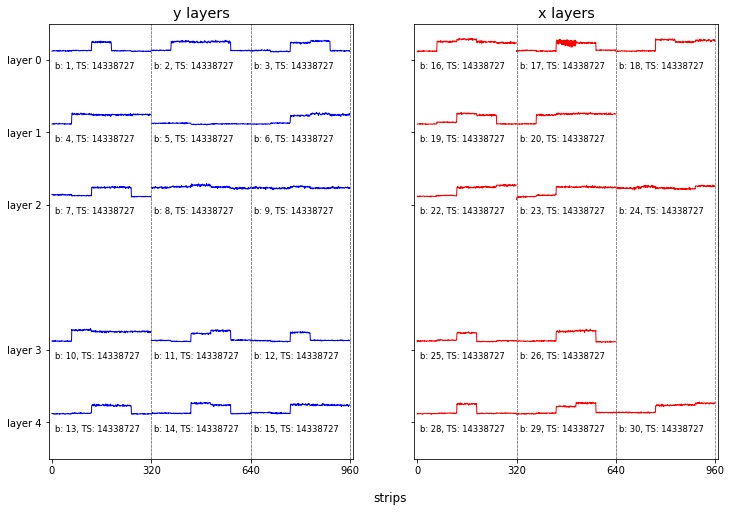

1329932992


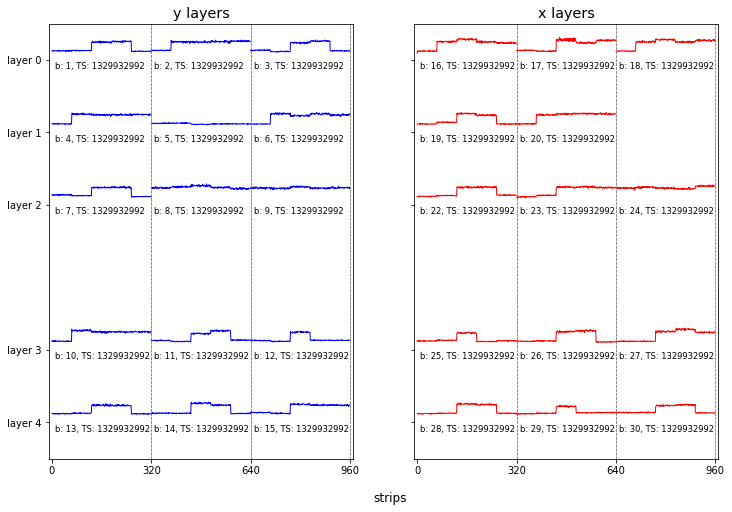

78148367


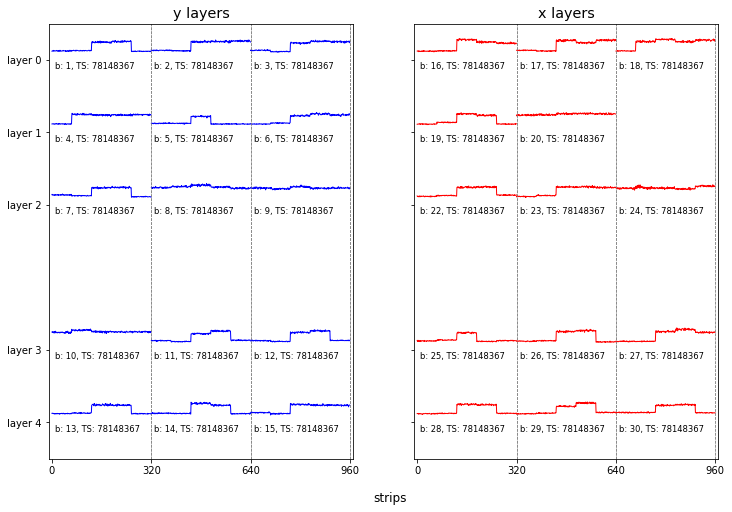

174509611


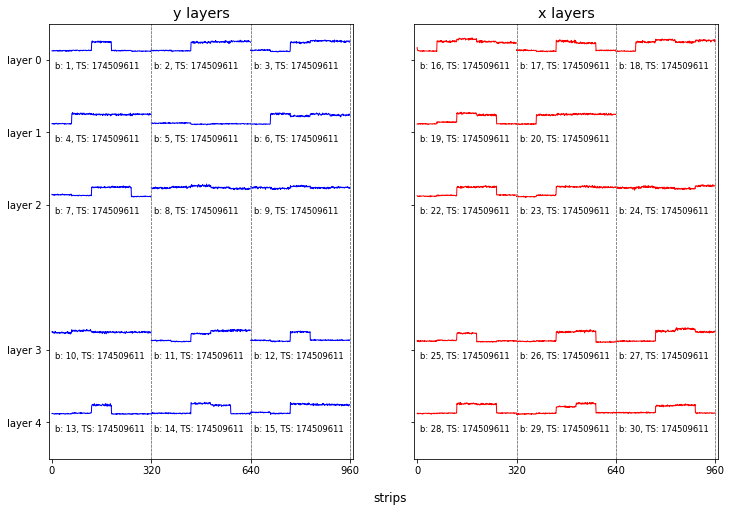

213038561


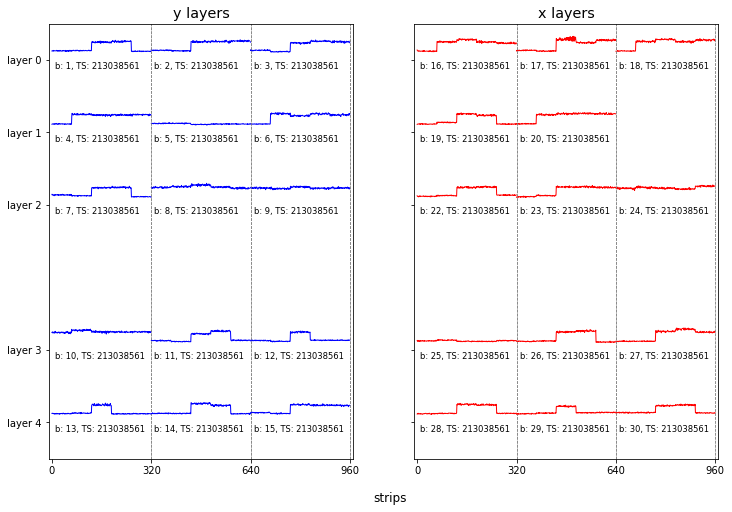

285460945


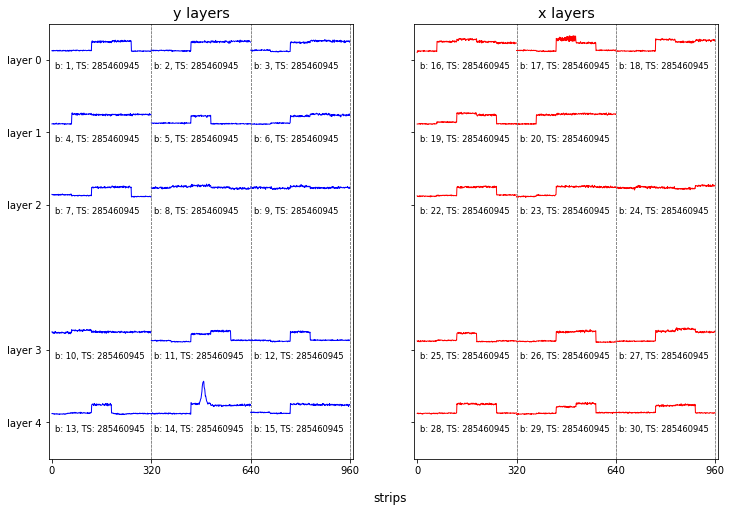

367652661


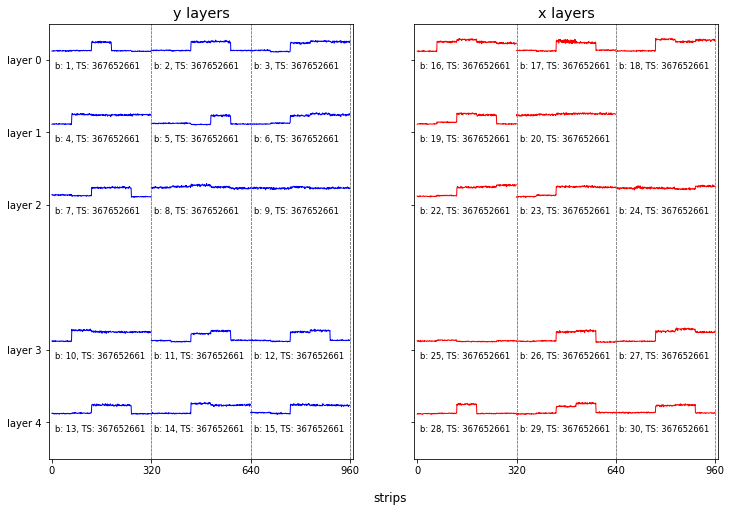

370764756


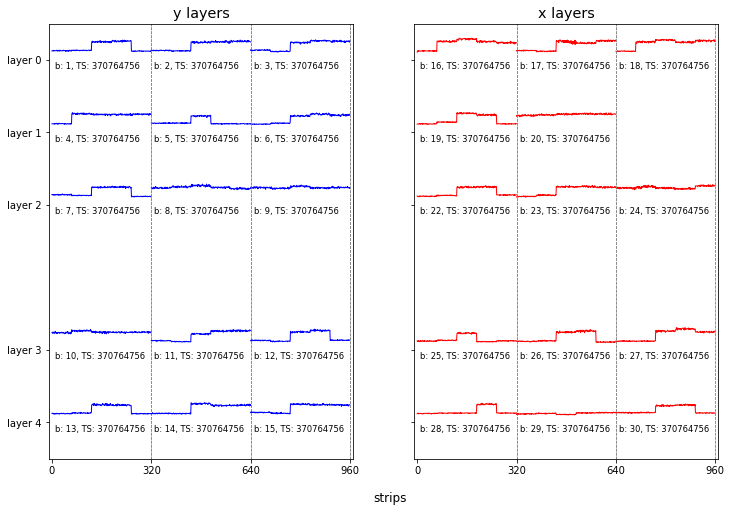

533192786


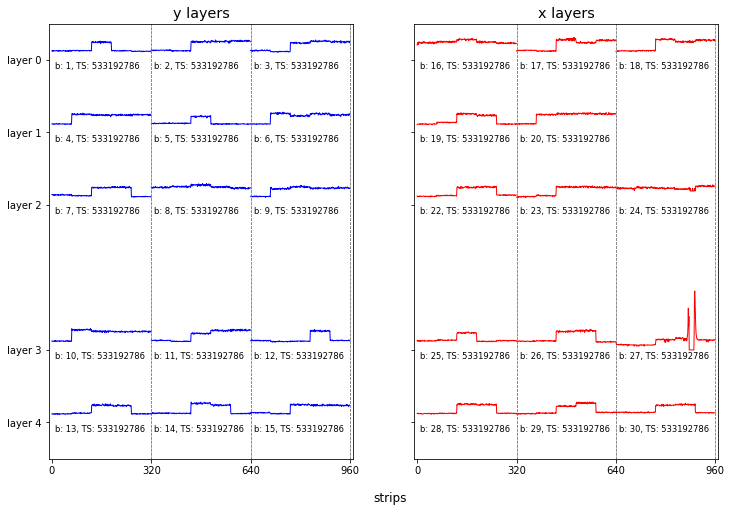

637389795


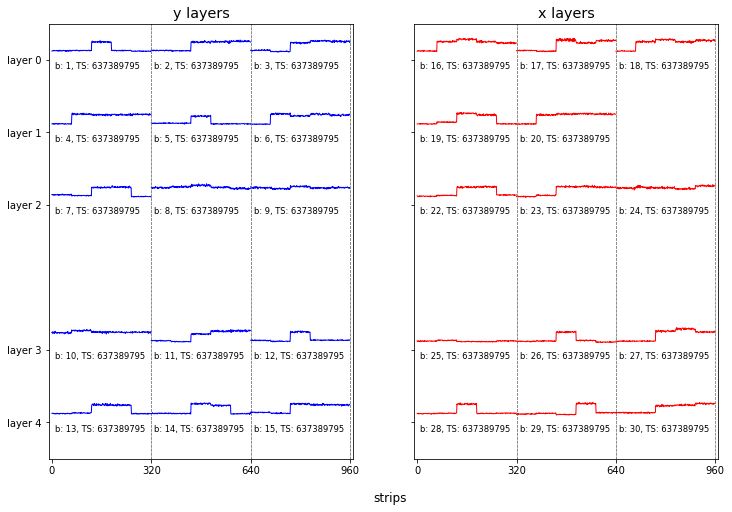

783133352


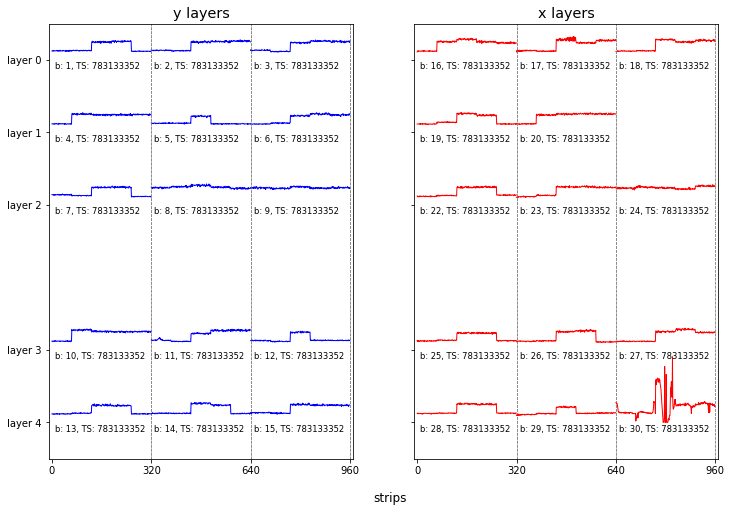

787360720


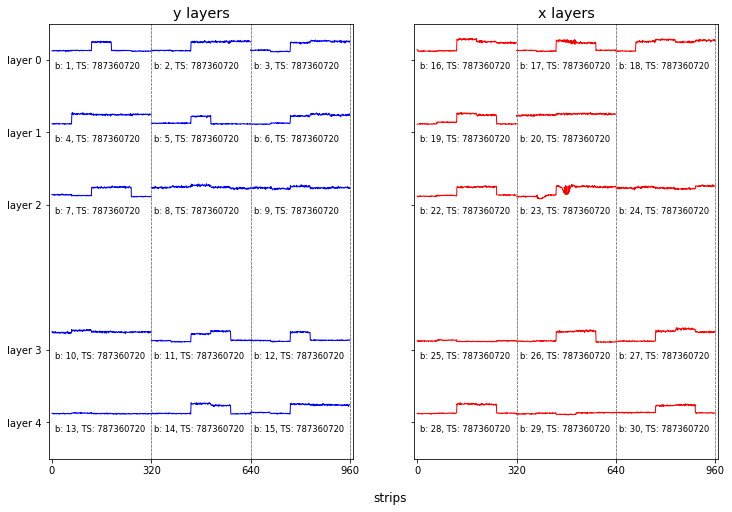

854266533


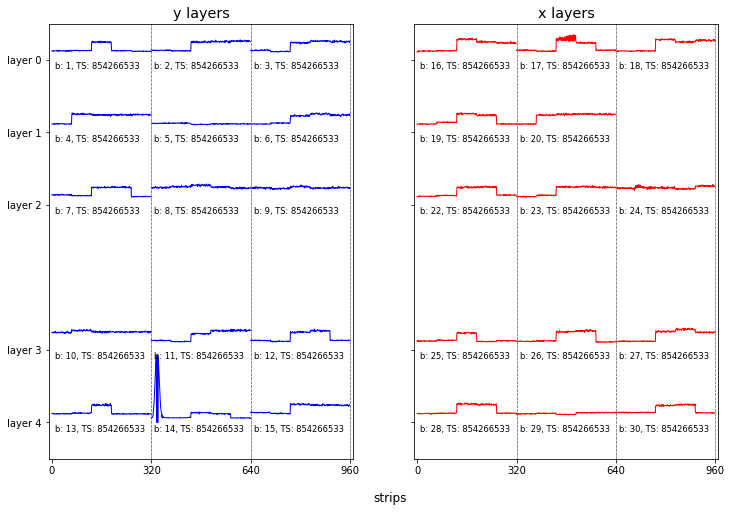

1007924506


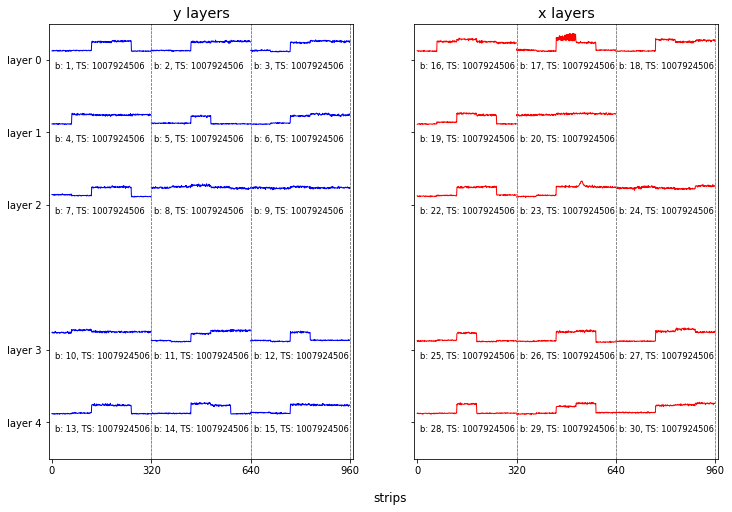

1125689411


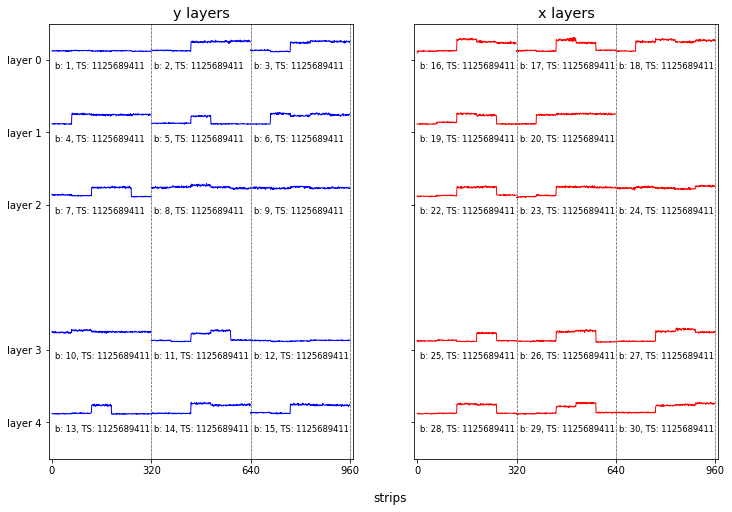

1145989420


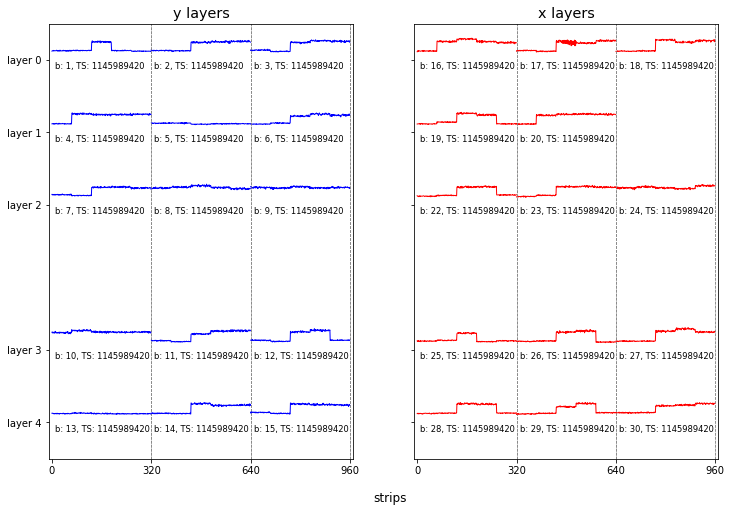

1263549022


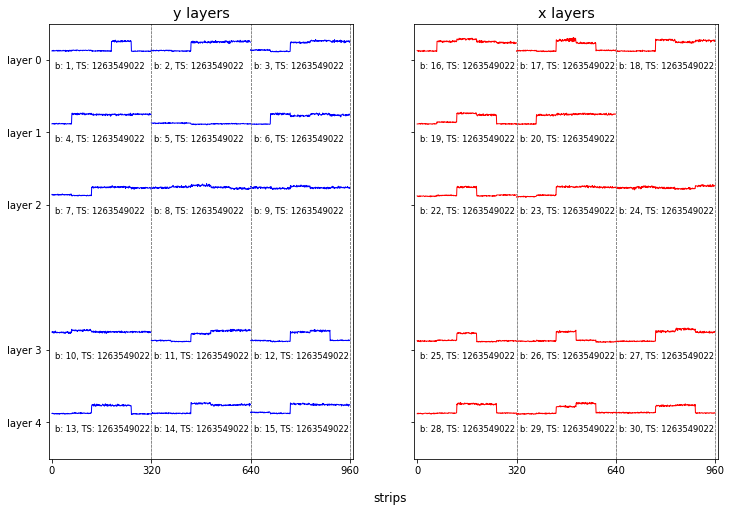

1295068394


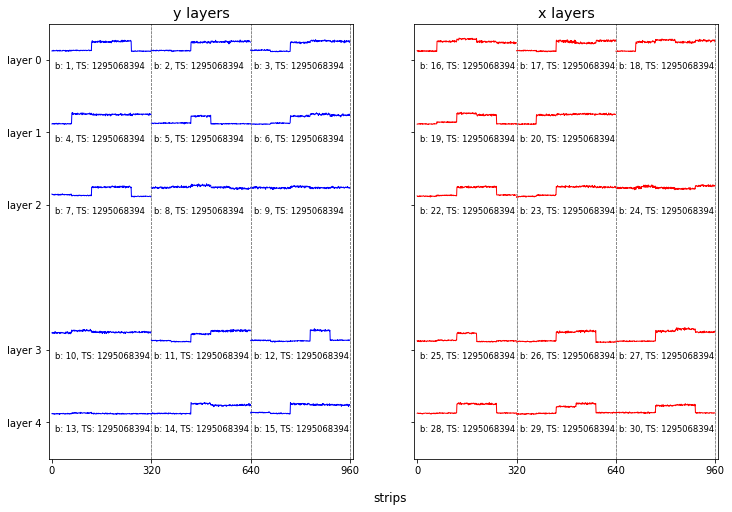

1373003575


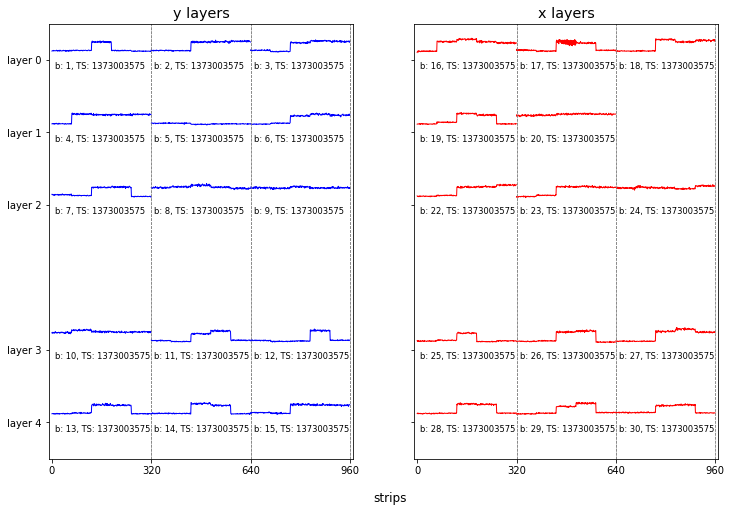

1676222274


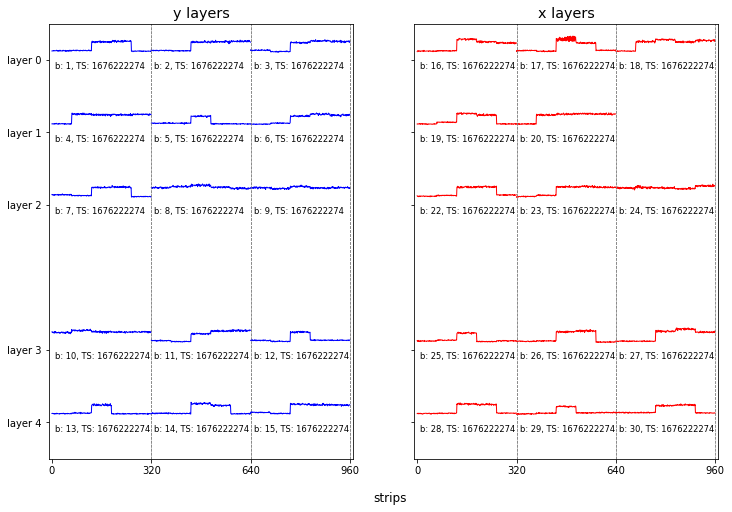

1682726533


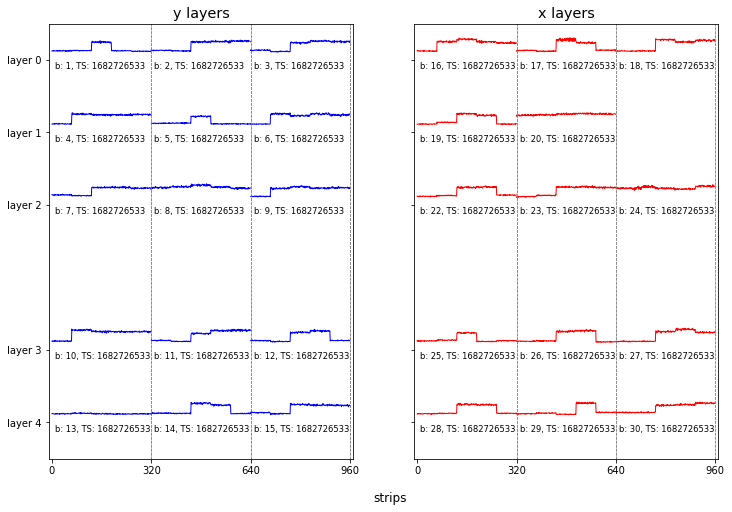

1760904836


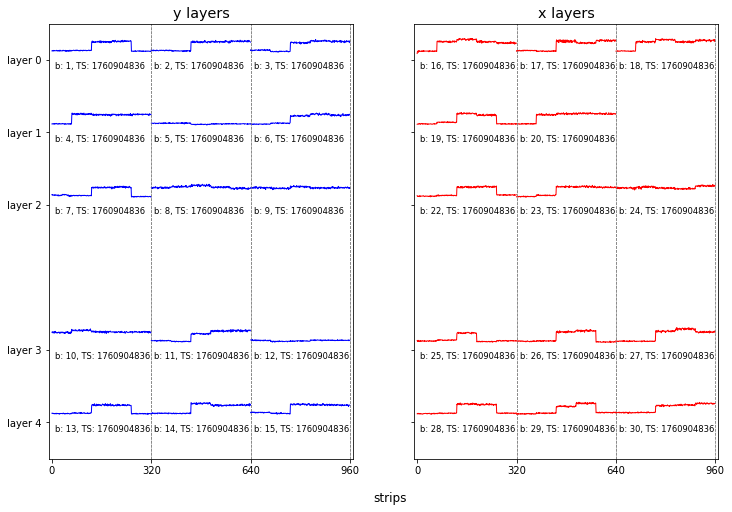

1799940616


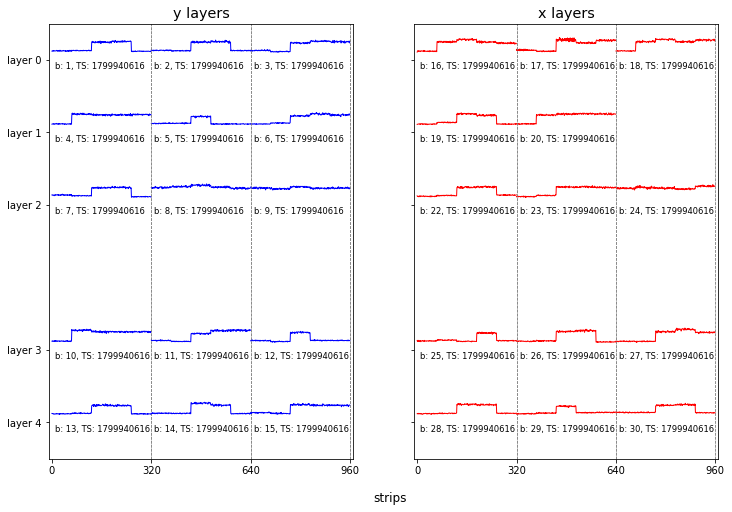

1944848384


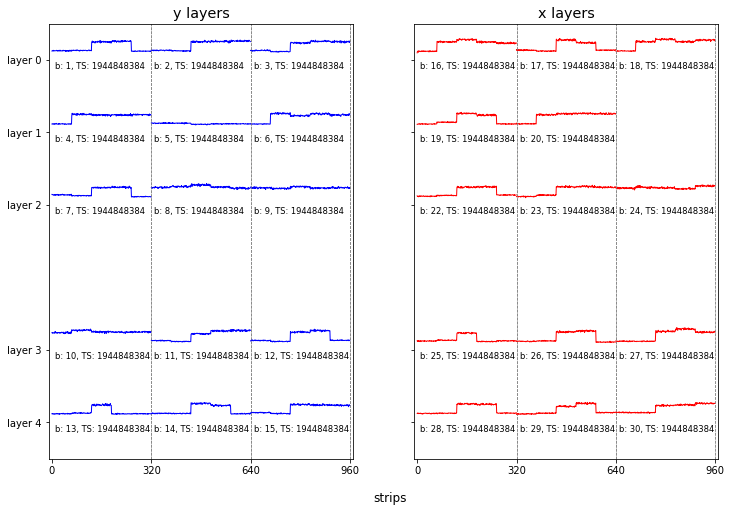

1976716752


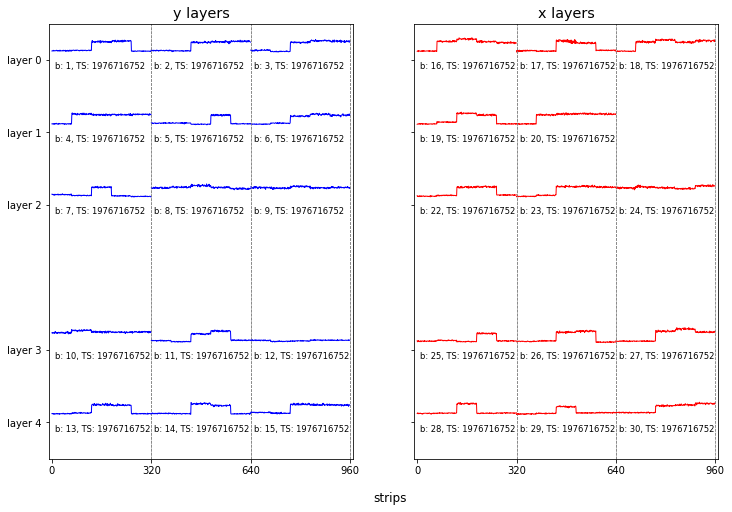

1987784774


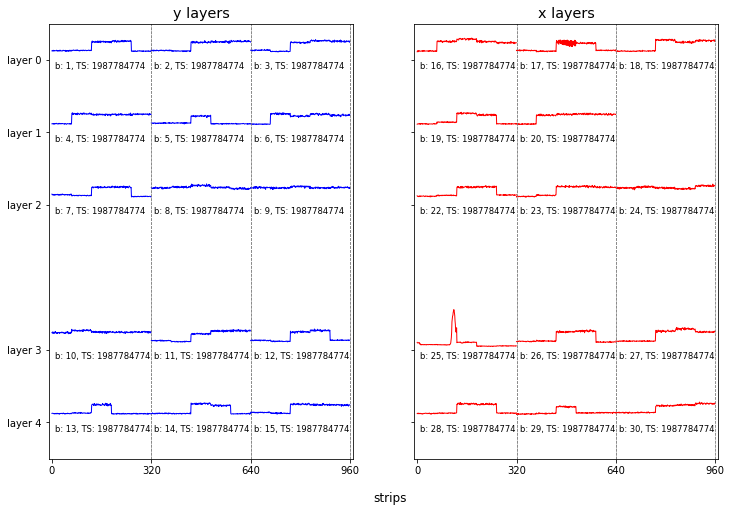

2034699677


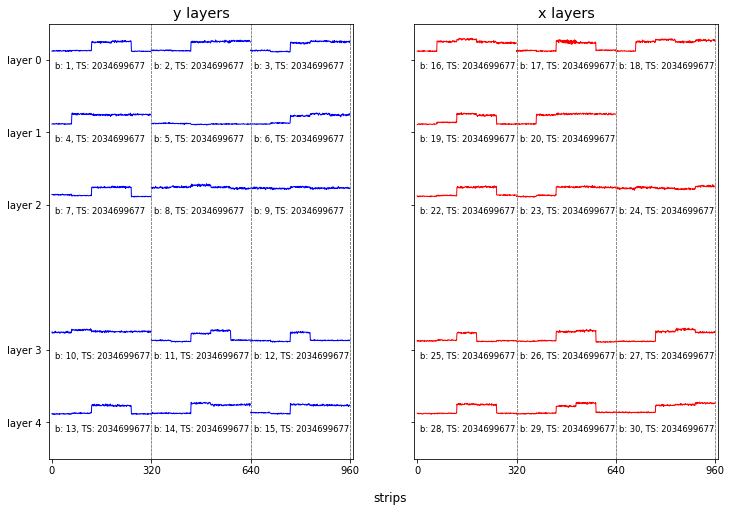

2091932427


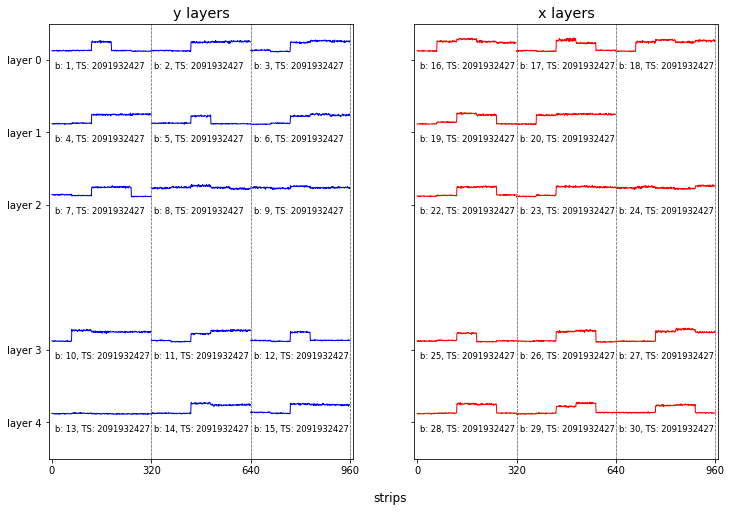

2104229251


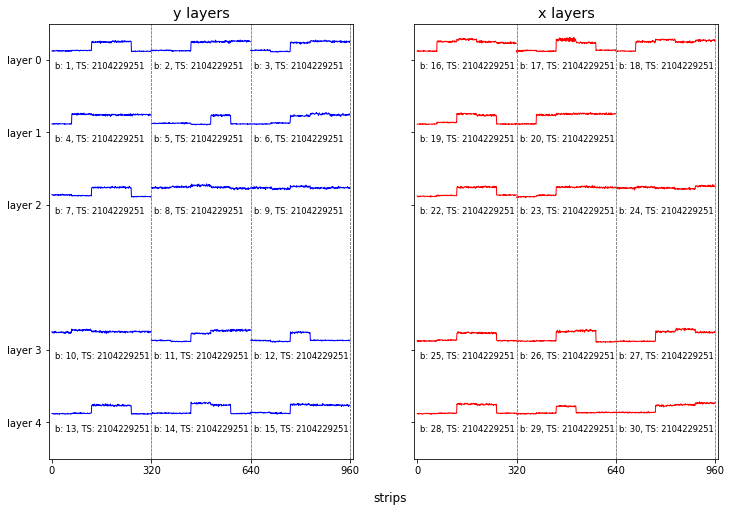

223192890


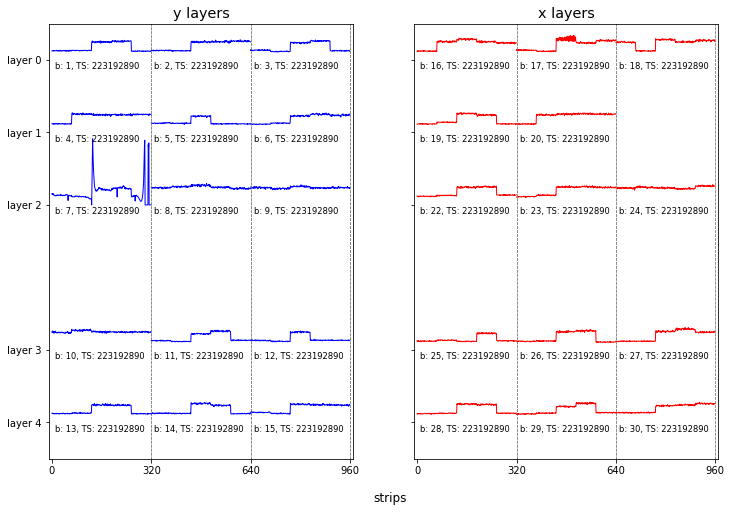

1944313368


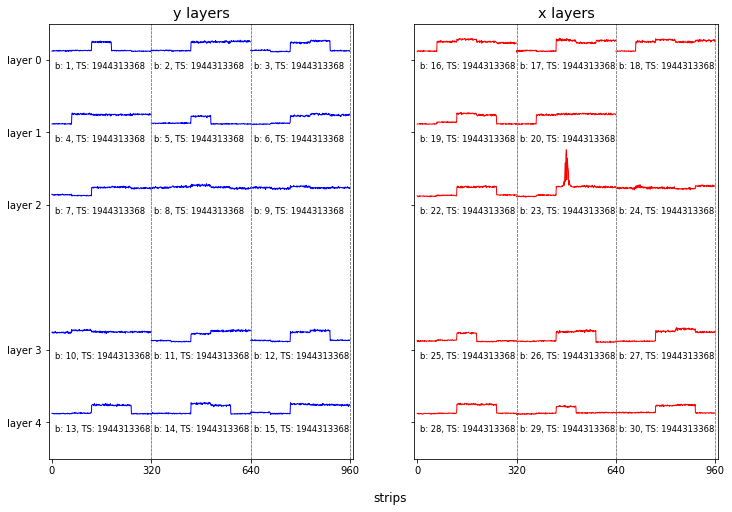

1969458795


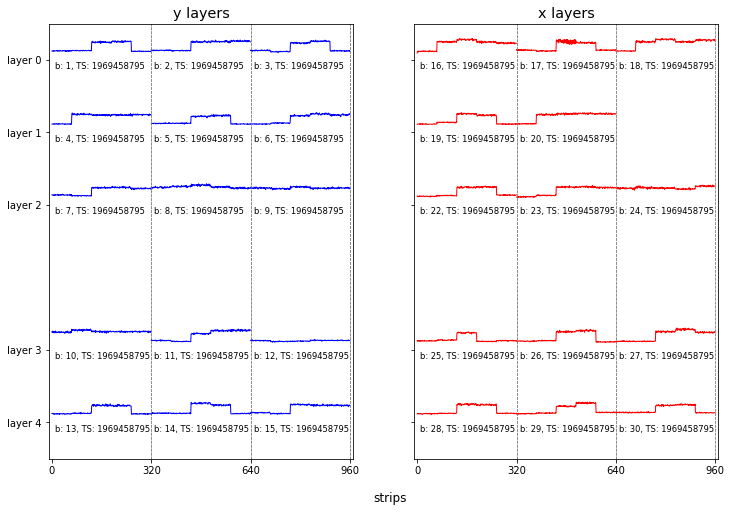

1970661976


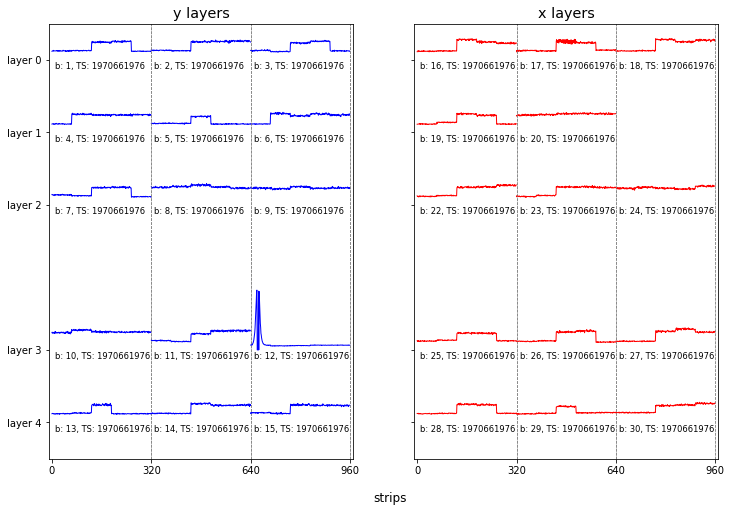

593463543


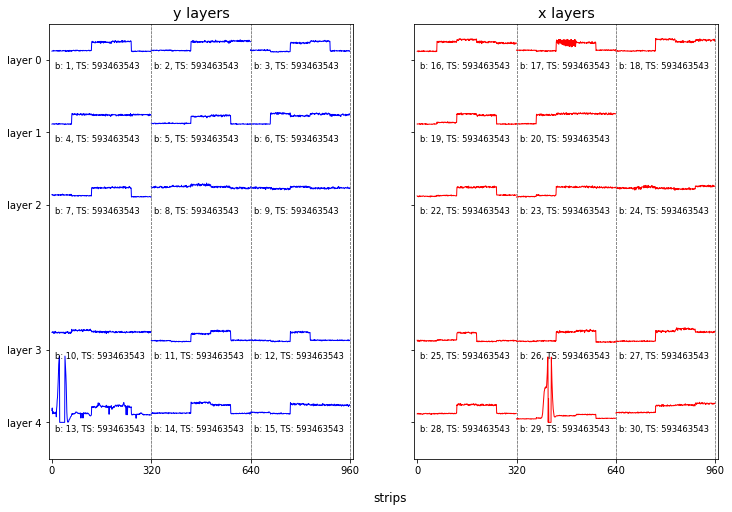

268411112


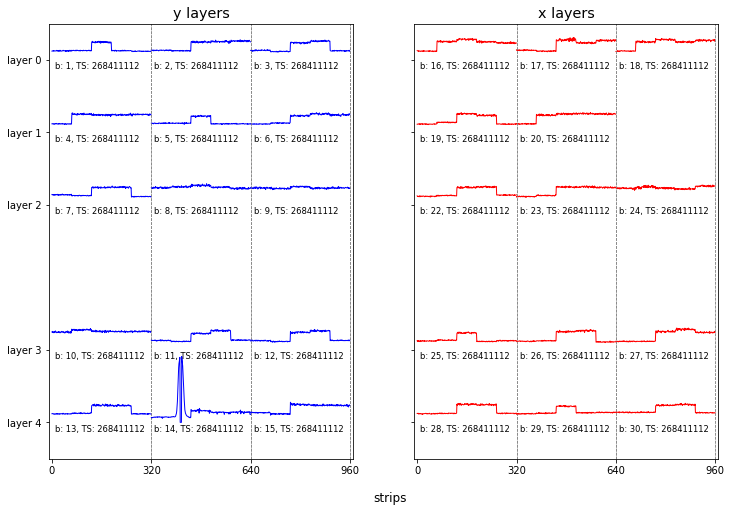

367188842


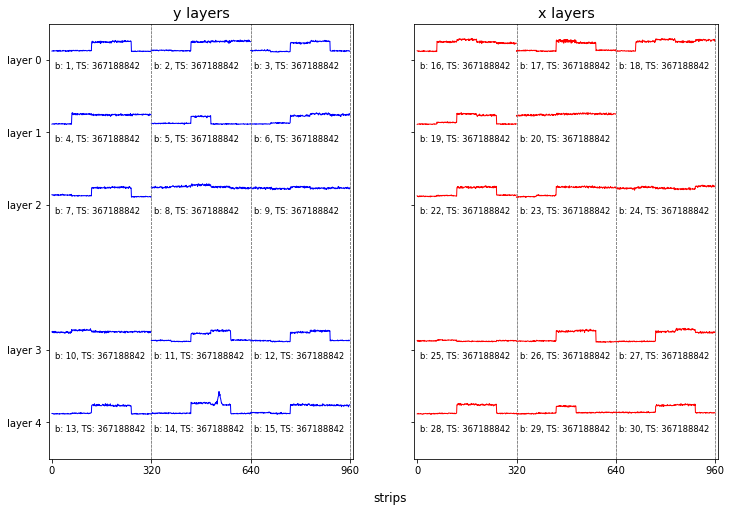

1686777942


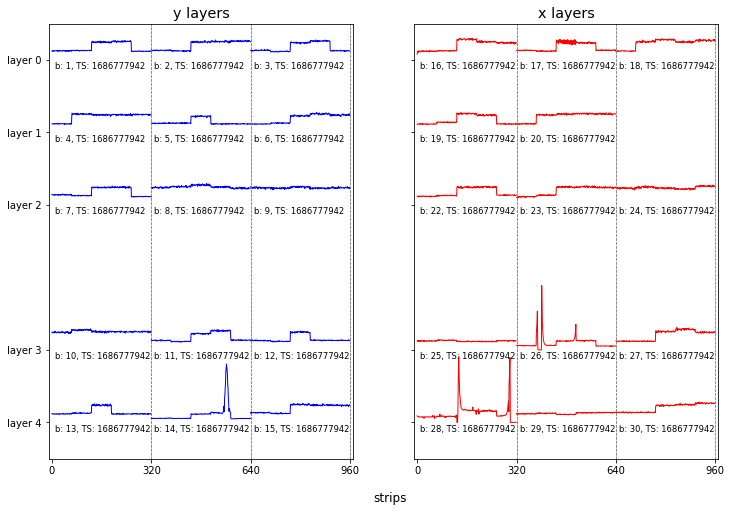

255361695


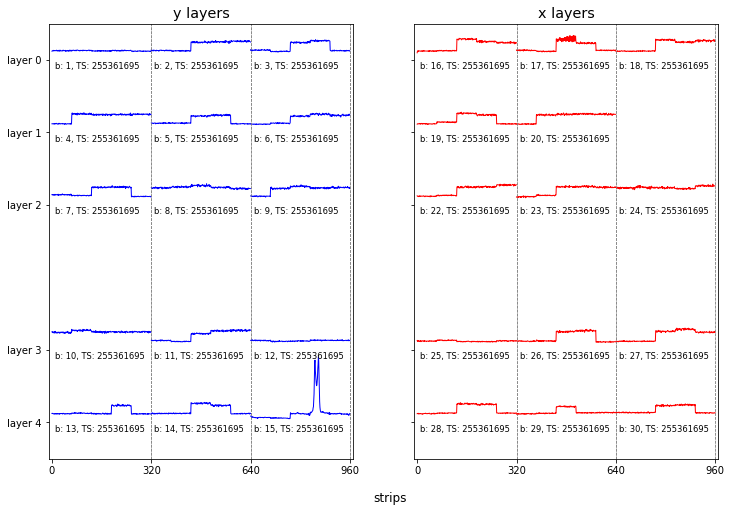

2093498542


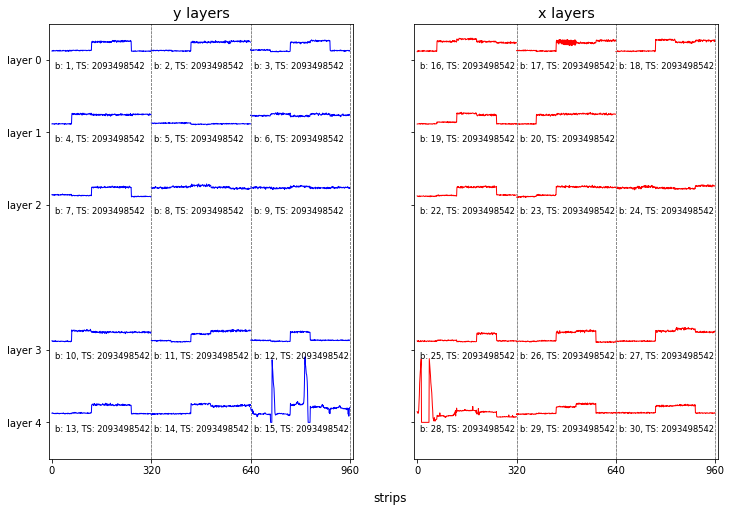

1989240986


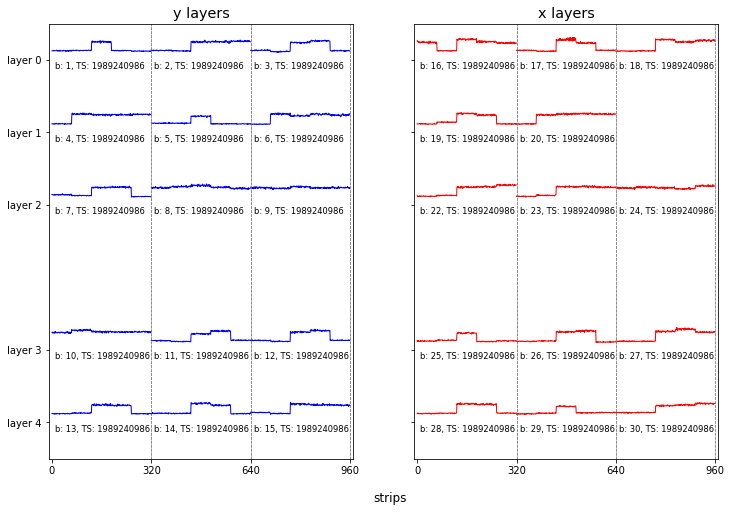

None


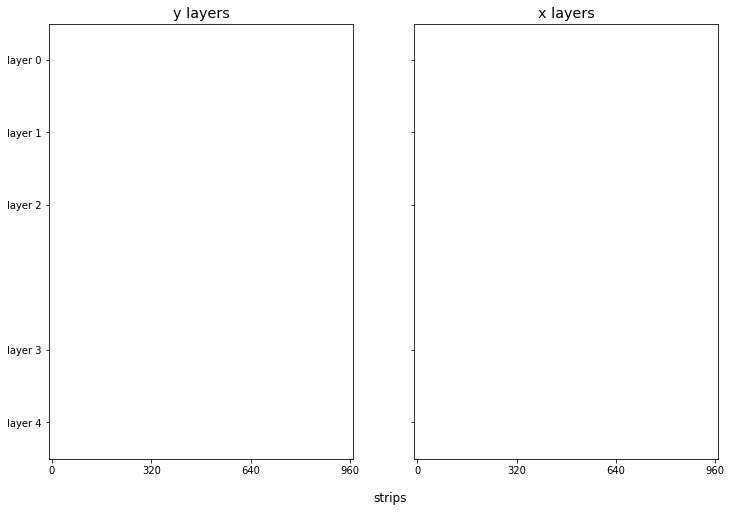

166645866


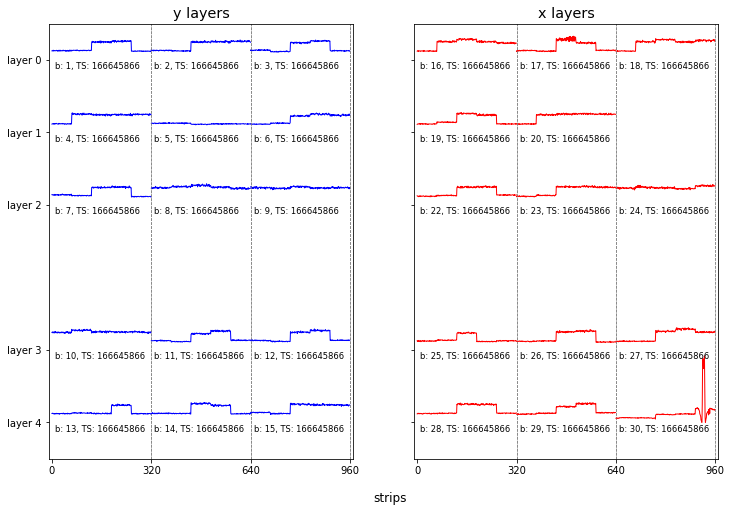

591096275


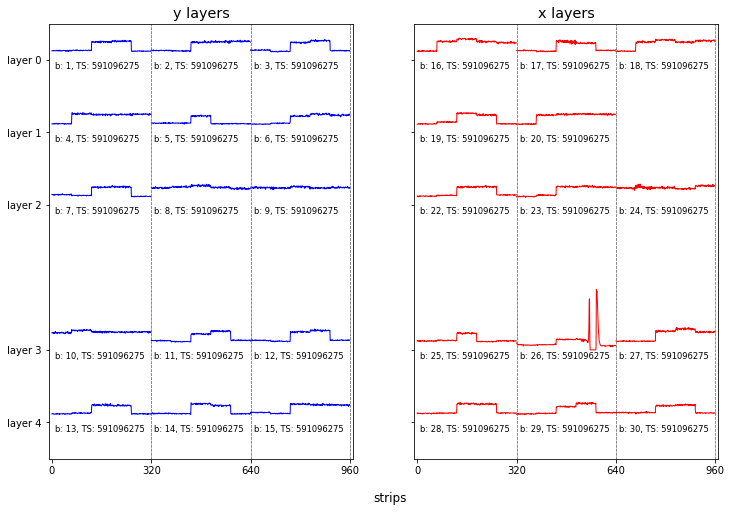

710531031


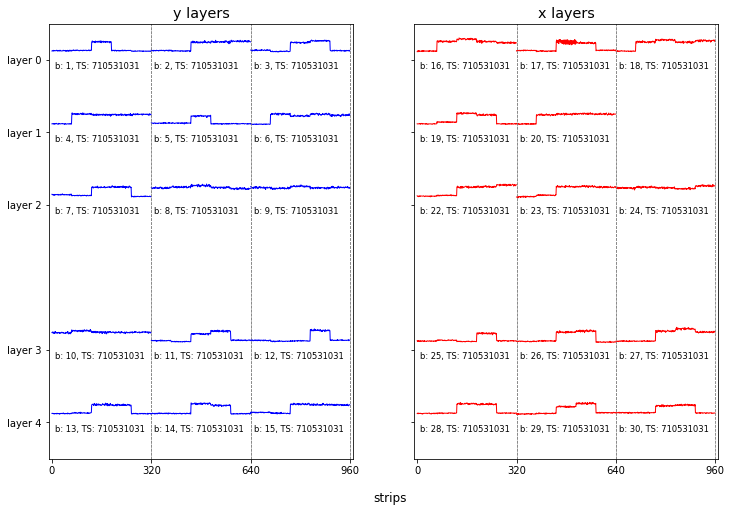

1231808613


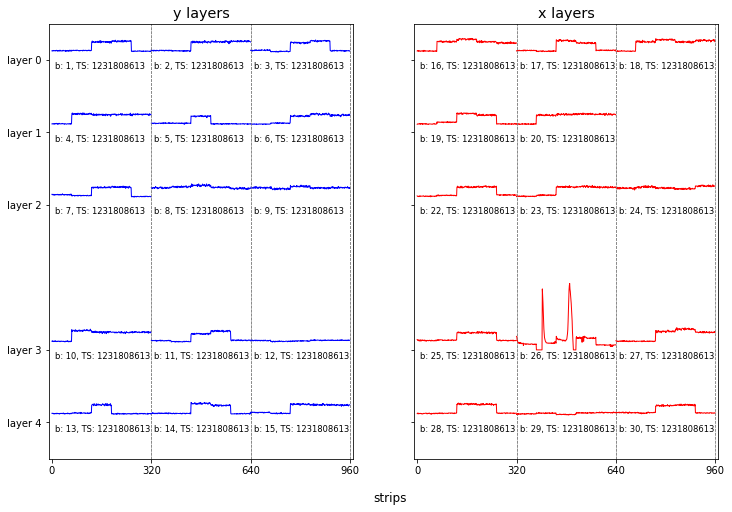

1276400737


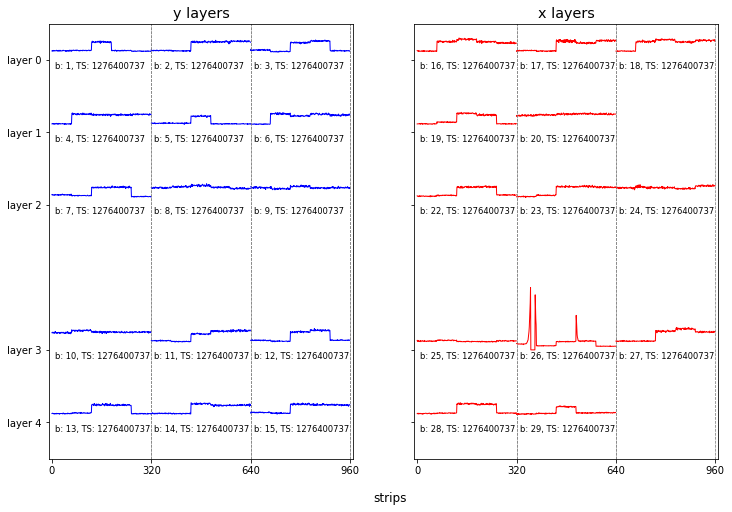

1446240063


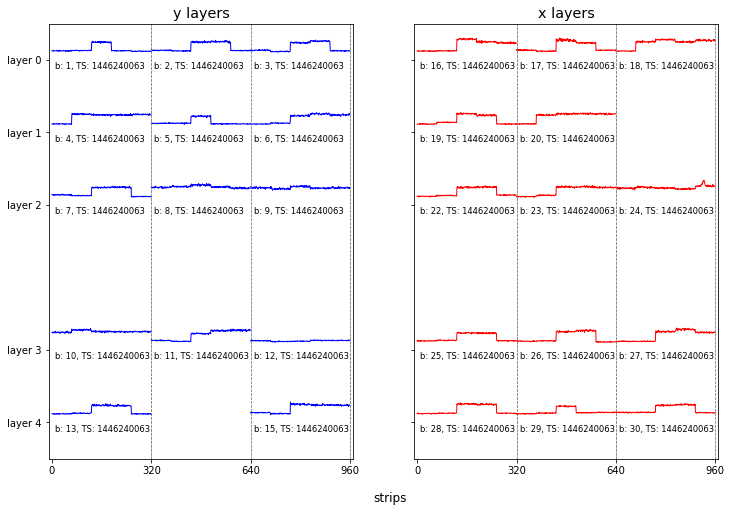

1483173091


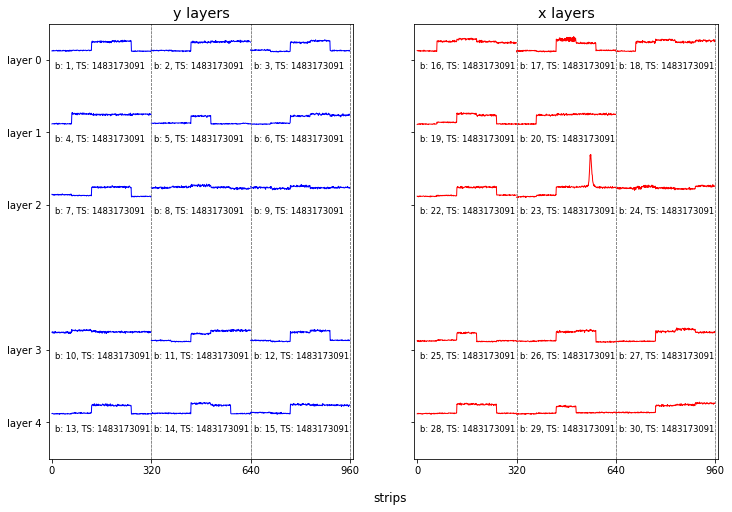

1762193533


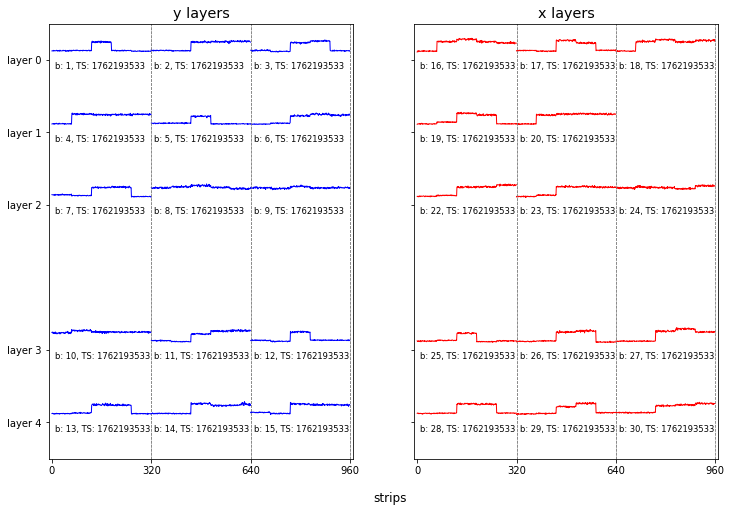

1848780884


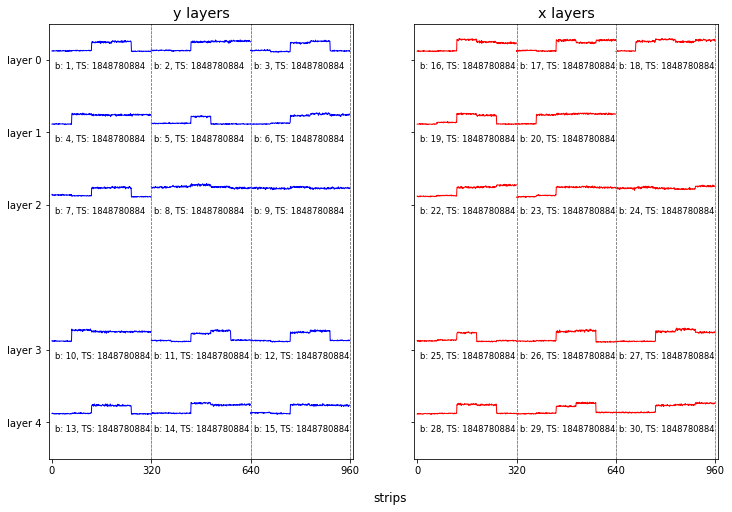

1960166887


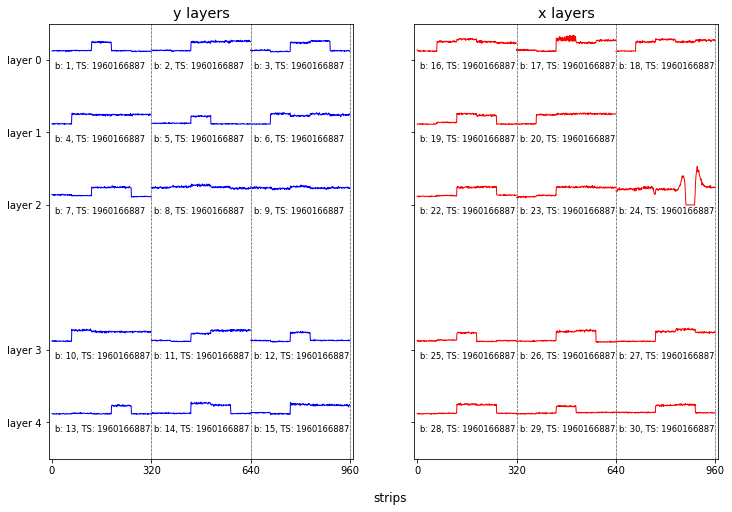

2002125360


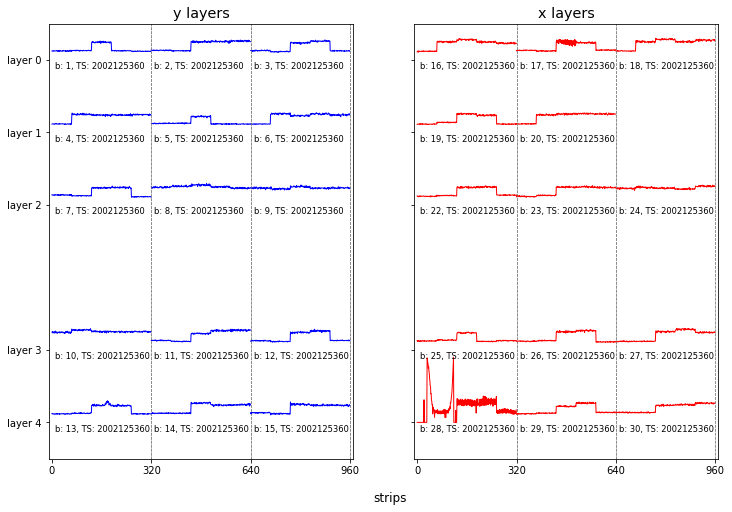

1340165736


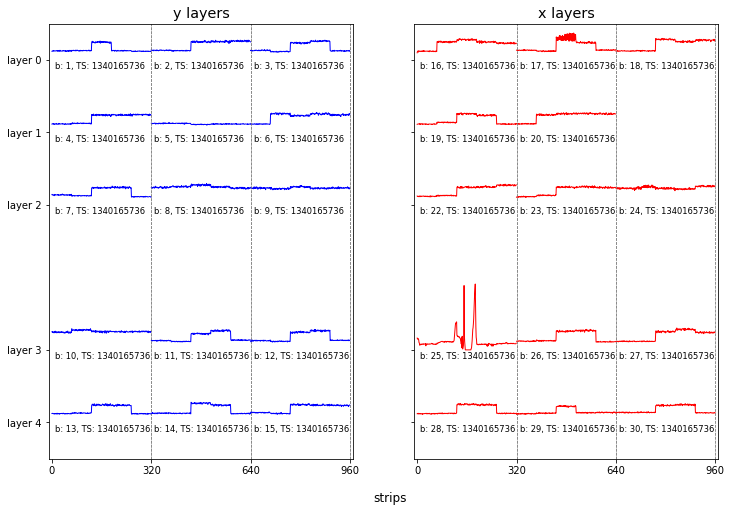

1863231767


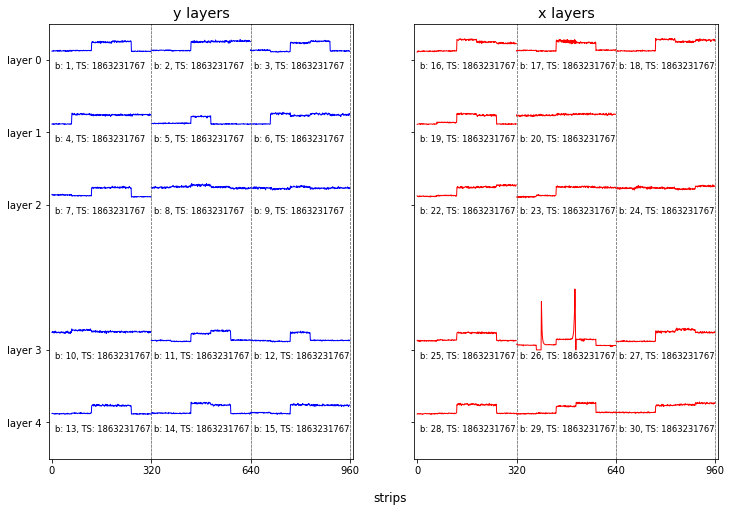

530427994


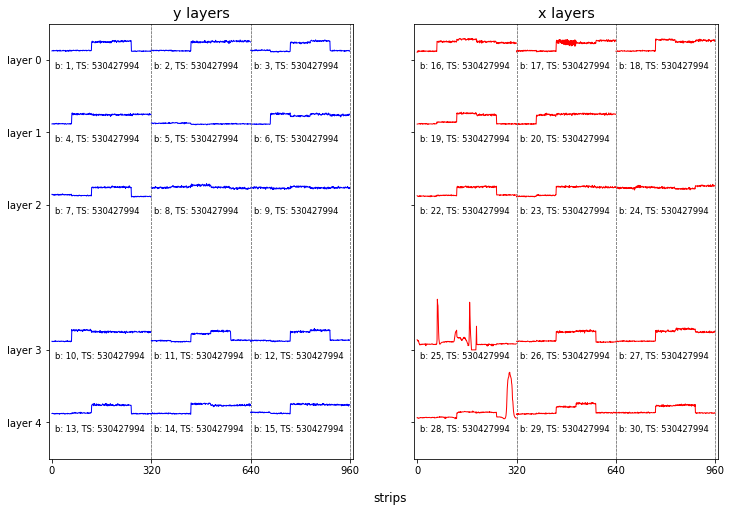

402159538


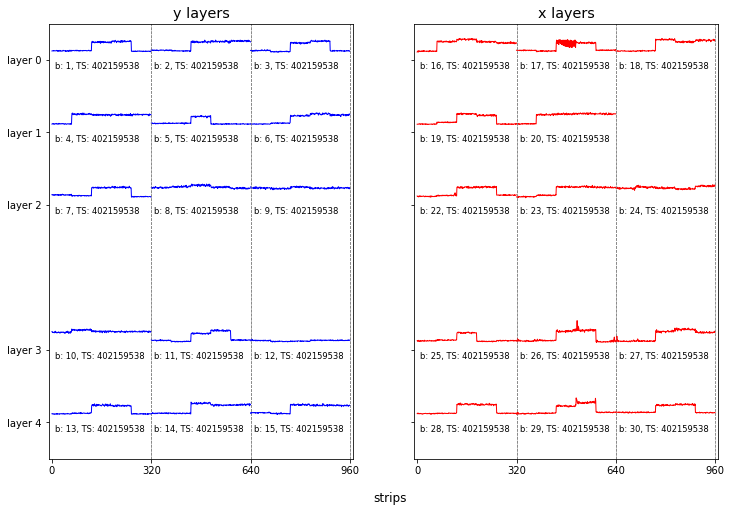

532090113


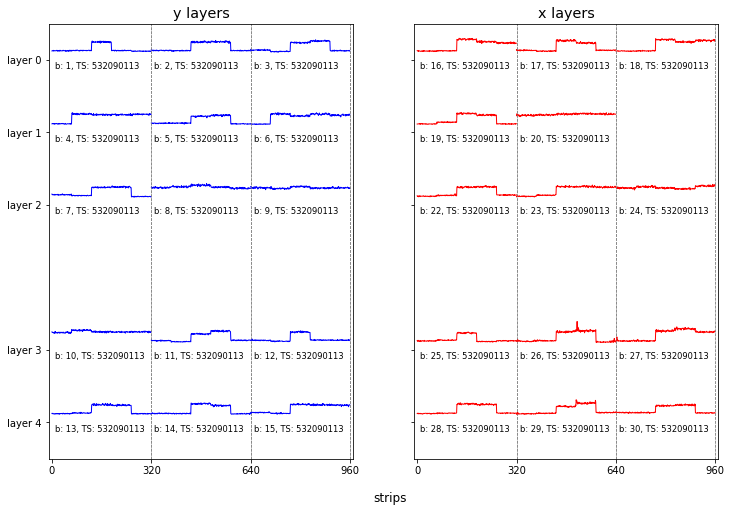

2086762648


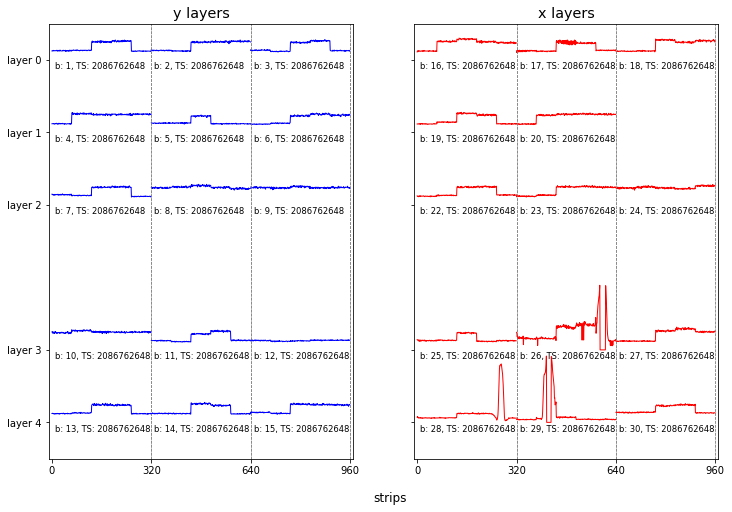

In [91]:
for ts in ts_to_plot:
    plot_event_ts_new(ts, marocdata)
    plt.show()

In [35]:
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("Run000109218_output_ts_clean_fixed_p1.pdf")
for ts in ts_to_plot:
    fig, ax1, ax2 = plot_event_ts_new(ts, marocdata)
    pdf.savefig(fig)
    plt.close(fig)
pdf.close()
plt.close()

14338727
1944313368
1970661976
593463543
1686777942
255361695
2093498542
1340165736
1863231767
530427994
2086762648


In [22]:

d1 = {str(k): value for k, value in counts_per_board1.items()}
d2 = {str(k): value for k, value in counts_per_board2.items()}


In [23]:
json.dump([d1], open("myfile.txt",'w'))

In [24]:
json.dump([d2], open("myfile1.txt",'w'))

In [17]:
outfile = "myfile1.txt"

In [25]:
out_1 =  "../readmaroc/data/farm/Run000061649_counts_thresh100.json"
out_2 = "../readmaroc/data/farm/Run000061673_counts_thresh100.json"

In [29]:
with open(out_1) as file1:
    data1 = json.load(file1)

In [30]:
with open(out_2) as file2:
    data2 = json.load(file2)

In [31]:
data1

{'1': 0,
 '2': 16,
 '3': 0,
 '4': 2,
 '5': 5,
 '6': 0,
 '7': 11,
 '8': 0,
 '9': 0,
 '10': 5,
 '11': 0,
 '12': 0,
 '13': 0,
 '14': 0,
 '15': 7,
 '16': 27,
 '17': 1,
 '18': 9,
 '19': 7,
 '20': 0,
 '22': 39,
 '23': 10,
 '24': 0,
 '25': 7,
 '26': 7,
 '27': 8,
 '28': 6,
 '29': 0,
 '30': 0}

In [32]:
data2

{'1': 0,
 '2': 15,
 '3': 0,
 '4': 0,
 '5': 5,
 '6': 0,
 '7': 11,
 '8': 0,
 '9': 0,
 '10': 4,
 '11': 0,
 '12': 0,
 '13': 1,
 '14': 0,
 '15': 5,
 '16': 28,
 '17': 2,
 '18': 157,
 '19': 9,
 '20': 0,
 '22': 45,
 '23': 6,
 '24': 2,
 '25': 6,
 '26': 5,
 '27': 2,
 '28': 6,
 '29': 0,
 '30': 0}

In [33]:
list_of_dicts = [d for d in [data1, data2]]
out = dict(reduce(add, map(Counter, list_of_dicts)))

In [34]:
out

{'2': 31,
 '4': 2,
 '5': 10,
 '7': 22,
 '10': 9,
 '13': 1,
 '15': 12,
 '16': 55,
 '17': 3,
 '18': 166,
 '19': 16,
 '22': 84,
 '23': 16,
 '24': 2,
 '25': 13,
 '26': 12,
 '27': 10,
 '28': 12}

In [142]:
folder = '/Users/yw18581/Downloads/test/'

In [143]:
test_multiload_100 = [json.load(open(os.path.join(folder, '{}'.format(f)))) for f in os.listdir(folder) if f.endswith('thresh100.json')]

In [144]:
test_multiload_200 = [json.load(open(os.path.join(folder, '{}'.format(f)))) for f in os.listdir(folder) if f.endswith('thresh200.json')]

In [145]:
test_multiload_300 = [json.load(open(os.path.join(folder, '{}'.format(f)))) for f in os.listdir(folder) if f.endswith('thresh300.json')]

In [146]:
test_multiload_100

[{'1': 0,
  '2': 1,
  '3': 94,
  '4': 2,
  '5': 4,
  '6': 0,
  '7': 6,
  '8': 1,
  '9': 0,
  '10': 0,
  '11': 0,
  '12': 1,
  '13': 1,
  '14': 6,
  '15': 1,
  '16': 5,
  '18': 74,
  '19': 1,
  '20': 119,
  '21': 64,
  '22': 8,
  '23': 5,
  '24': 0,
  '25': 4,
  '26': 4,
  '27': 12,
  '28': 1,
  '29': 0,
  '30': 1},
 {'1': 0,
  '2': 0,
  '3': 61,
  '4': 0,
  '5': 4,
  '6': 151,
  '7': 4,
  '8': 1,
  '9': 0,
  '10': 0,
  '11': 0,
  '12': 0,
  '13': 1,
  '14': 10,
  '15': 4,
  '16': 4,
  '18': 67,
  '19': 0,
  '20': 108,
  '21': 41,
  '22': 11,
  '23': 1,
  '24': 0,
  '25': 4,
  '26': 6,
  '27': 7,
  '28': 8,
  '29': 5,
  '30': 3},
 {'1': 1,
  '2': 4,
  '3': 86,
  '4': 2,
  '5': 6,
  '6': 2,
  '7': 5,
  '8': 2,
  '9': 1,
  '10': 0,
  '11': 0,
  '12': 0,
  '13': 0,
  '14': 3,
  '15': 5,
  '16': 6,
  '18': 91,
  '19': 1,
  '20': 156,
  '21': 67,
  '22': 16,
  '23': 2,
  '24': 1,
  '25': 4,
  '26': 9,
  '27': 9,
  '28': 11,
  '29': 2,
  '30': 2},
 {'1': 0,
  '2': 0,
  '3': 53,
  '4': 0,
  '5

In [148]:
len(test_multiload_100leb

1998

In [128]:
test_multiload_300

[{'1': 0,
  '2': 0,
  '3': 0,
  '4': 2,
  '5': 5,
  '6': 0,
  '7': 0,
  '8': 1,
  '9': 0,
  '10': 0,
  '11': 0,
  '12': 3,
  '13': 0,
  '14': 2,
  '15': 2,
  '16': 4,
  '17': 0,
  '18': 0,
  '19': 0,
  '20': 0,
  '22': 0,
  '23': 0,
  '24': 0,
  '25': 3,
  '26': 5,
  '27': 3,
  '28': 4,
  '29': 1,
  '30': 1},
 {'1': 0,
  '2': 1,
  '3': 0,
  '4': 1,
  '5': 7,
  '6': 0,
  '7': 1,
  '8': 0,
  '9': 0,
  '10': 0,
  '11': 0,
  '12': 1,
  '13': 1,
  '14': 1,
  '15': 1,
  '16': 13,
  '17': 0,
  '18': 0,
  '19': 0,
  '20': 0,
  '22': 0,
  '23': 1,
  '24': 0,
  '25': 0,
  '26': 2,
  '27': 1,
  '28': 0,
  '29': 0,
  '30': 0},
 {'1': 0,
  '2': 0,
  '3': 0,
  '4': 1,
  '5': 5,
  '6': 0,
  '7': 0,
  '8': 0,
  '9': 0,
  '10': 0,
  '11': 0,
  '12': 1,
  '13': 0,
  '14': 2,
  '15': 4,
  '16': 4,
  '17': 0,
  '18': 0,
  '19': 0,
  '20': 0,
  '22': 0,
  '23': 1,
  '24': 0,
  '25': 1,
  '26': 5,
  '27': 3,
  '28': 3,
  '29': 1,
  '30': 0},
 {'1': 0,
  '2': 0,
  '3': 0,
  '4': 0,
  '5': 6,
  '6': 0,
  '7':

In [149]:
out_100 = dict(reduce(add, map(Counter, test_multiload_100)))


In [150]:
out_100

{'2': 3862,
 '3': 144163,
 '4': 3268,
 '5': 8831,
 '6': 151271,
 '7': 13663,
 '8': 5263,
 '12': 2803,
 '13': 2993,
 '14': 145167,
 '15': 11443,
 '16': 10087,
 '18': 123807,
 '19': 2091,
 '20': 194011,
 '21': 104559,
 '22': 26927,
 '23': 7605,
 '25': 11690,
 '26': 11619,
 '27': 21139,
 '28': 13062,
 '29': 9729,
 '30': 16964,
 '1': 523,
 '9': 543,
 '24': 883,
 '10': 1340,
 '11': 253}

In [151]:
out_200 = dict(reduce(add, map(Counter, test_multiload_200)))

In [152]:
out_200

{'1': 337,
 '2': 3677,
 '3': 62112,
 '4': 2165,
 '5': 8718,
 '6': 763,
 '7': 11849,
 '8': 2643,
 '9': 464,
 '10': 1043,
 '12': 2636,
 '13': 2605,
 '14': 11942,
 '15': 9912,
 '16': 8991,
 '18': 80521,
 '19': 1680,
 '20': 7518,
 '21': 88005,
 '22': 26488,
 '23': 4108,
 '24': 766,
 '25': 11547,
 '26': 10914,
 '27': 20021,
 '28': 12525,
 '29': 9554,
 '30': 6614,
 '11': 202}

In [153]:
out_300 = dict(reduce(add, map(Counter, test_multiload_300)))

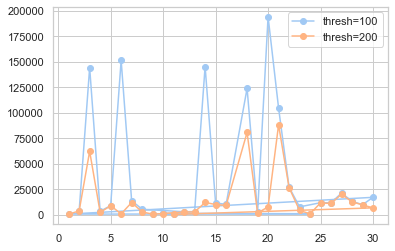

In [154]:
plt.plot([int(i) for i in out_100.keys()], out_100.values(),'o-', label='thresh=100')
plt.plot([int(i) for i in out_200.keys()], out_200.values(),'o-', label='thresh=200')
plt.legend()
plt.show()

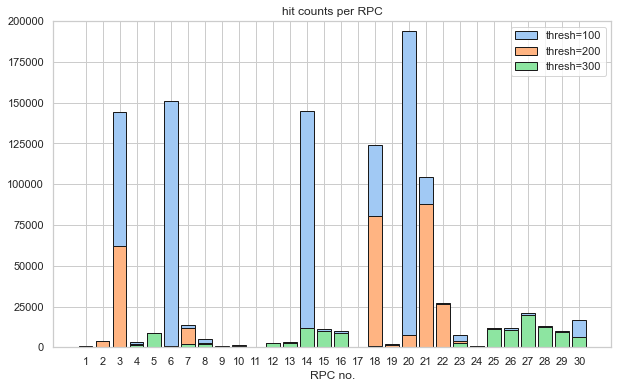

In [160]:
plt.figure(figsize=(10,6))
sns.set_theme(style="whitegrid", palette="pastel")
plt.bar([int(i) for i in out_100.keys()], out_100.values(), edgecolor='k',label='thresh=100')
plt.bar([int(i) for i in out_200.keys()], out_200.values(), edgecolor='k',label='thresh=200')
plt.bar([int(i) for i in out_300.keys()], out_300.values(), edgecolor='k',label='thresh=300')
plt.xlabel('RPC no.')
plt.title('hit counts per RPC')
plt.legend()
plt.xticks(range(1,31))
plt.ylim(0,200000)
plt.show()

import seaborn as sns
sns.set_theme(style="darkgrid")
ax = sns.countplot([np.ones([int(j)])*int(i) for i,j in out_200.items()])

In [2]:
import json

In [15]:
with open('out_5_sigma.json') as f:
    output_7sigma = json.load(f)
    

In [16]:
with open('out_3_sigma.json') as f:
    output_3sigma = json.load(f)
    

In [18]:
with open('out_5sigmanew.json') as f:
    output_5sigma = json.load(f)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

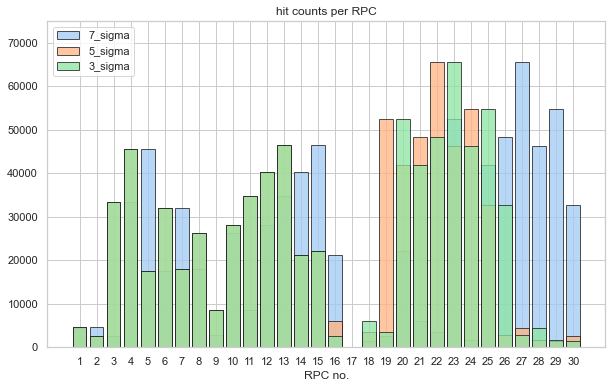

In [19]:
plt.figure(figsize=(10,6))
sns.set_theme(style="whitegrid", palette="pastel")
plt.bar([int(i) for i in output_7sigma.keys()], output.values(), edgecolor='k',label='7_sigma', alpha=.75)
plt.bar([int(i) for i in output_5sigma.keys()], output.values(), edgecolor='k',label='5_sigma', alpha=.75)
plt.bar([int(i) for i in output_3sigma.keys()], output.values(), edgecolor='k',label='3_sigma', alpha=.75)



plt.xlabel('RPC no.')
plt.title('hit counts per RPC')
plt.legend()
plt.xticks(range(1,31))
plt.ylim(0,75000)
plt.show()